This notebook demonstrates steps of creating a pipeline of model training and testing

<!-- %pip install -q transformers datasets evaluate -->

In [1]:
!git clone https://github.com/OopsWrongCode/nlp-project.git

Cloning into 'nlp-project'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 129 (delta 16), reused 38 (delta 12), pack-reused 84 (from 1)
Receiving objects: 100% (129/129), 46.71 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
%cd nlp-project/

/kaggle/working/nlp-project


In [3]:
%pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
import random
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
# from datasets import Dataset

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
train = pd.read_csv('/kaggle/working/nlp-project/data/train.csv')
test = pd.read_csv('/kaggle/working/nlp-project/data/test.csv')
validation = pd.read_csv('/kaggle/working/nlp-project/data/valid.csv')

In [6]:
train['token_count'] = [len(sentence.split()) for sentence in train['text']]
train['text_length'] = [len(seq) for seq in train['text']]

In [7]:
train.head()

,text,label,token_count,text_length
0,"['didnt', 'feel', 'humiliated']",sadness,3,31
1,"['can', 'go', 'from', 'feeling', 'so', 'hopele...",sadness,20,167
2,"['im', 'grabbing', 'minute', 'to', 'post', 'fe...",anger,8,69
3,"['am', 'ever', 'feeling', 'nostalgic', 'about'...",love,16,137
4,"['am', 'feeling', 'grouchy']",anger,3,28


In [8]:
validation.head()

,text,label
0,"['im', 'feeling', 'quite', 'sad', 'and', 'sorr...",sadness
1,"['feel', 'like', 'am', 'still', 'looking', 'at...",sadness
2,"['feel', 'like', 'faithful', 'servant']",love
3,"['am', 'just', 'feeling', 'cranky', 'and', 'bl...",anger
4,"['can', 'have', 'for', 'treat', 'or', 'if', 'a...",joy


In [9]:
test.head()

,text,label
0,"['im', 'feeling', 'rather', 'rotten', 'so', 'i...",sadness
1,"['im', 'updating', 'my', 'blog', 'because', 'f...",sadness
2,"['never', 'make', 'her', 'separate', 'from', '...",sadness
3,"['left', 'with', 'my', 'bouquet', 'of', 'red',...",joy
4,"['was', 'feeling', 'little', 'vain', 'when', '...",sadness


In [10]:
mbti_types = train['label'].unique().tolist()

label_encoder = LabelEncoder()
label_encoder.fit(mbti_types)

train['label'] = label_encoder.transform(train['label'])
validation['label'] = label_encoder.transform(validation['label'])
test['label'] = label_encoder.transform(test['label'])


In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class MBTIDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = str(self.texts[index])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        if self.labels is not None:
            label = self.labels[index]
            return {
                'input_ids': encoding['input_ids'].squeeze(0),  # (max_len)
                'attention_mask': encoding['attention_mask'].squeeze(0),  # (max_len)
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': encoding['input_ids'].squeeze(0),  # (max_len)
                'attention_mask': encoding['attention_mask'].squeeze(0),  # (max_len)
            }

    def __len__(self):
        return len(self.texts)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
print(f"Max len = {np.max(train['token_count'])}\nMin len = {np.min(train['token_count'])}\nAvg len = {np.round(np.mean(train['token_count']), 2)}")

Max len = 60
Min len = 2
Avg len = 17.04


In [13]:
BATCH_SIZE = 64
MAX_LEN = np.max(train['token_count'])
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = MBTIDataset(texts=train['text'].tolist(), labels=train['label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN)
test_dataset = MBTIDataset(texts=test['text'].tolist(),labels=test['label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN)
validation_dataset = MBTIDataset(texts=validation['text'].tolist(), labels=validation['label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

For regularization, we employ two commonly used
techniques: dropout (Hinton et al., 2012) and L2
weight regularization. We apply dropout to prevent co-adaptation. In our model, we either apply
dropout to word vectors before feeding the sequence
of words into the convolutional layer or to the output
of LSTM before the softmax layer. The L2 regularization is applied to the weight of the softmax layer. (https://arxiv.org/pdf/1511.08630)

In [14]:
class MyLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim=6, num_layers=1, bidirectional=False, dropout=0.3, fc_dropout=0.3, input_dropout=0.2):
        super(MyLSTM, self).__init__()

        
        self.input_dropout = nn.Dropout(input_dropout) # 

        self.lstm = nn.LSTM(
            input_size=embedding_dim, # 768
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        # LAYER 2: Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(
            hidden_dim * (2 if bidirectional else 1),
            output_dim
        )

    def forward(self, bert_embeddings):  # [batch_size, seq_len, embedding_dim]

        # Dropout on BERT-embeddings
        x = self.input_dropout(bert_embeddings)

        lstm_output, (h_n, c_n) = self.lstm(x)

        if self.lstm.bidirectional:
            h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_final = h_n[-1]

        h_final = self.fc_dropout(h_final)
        out = self.fc(h_final)
        return out

In [15]:
class MyGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim=6, num_layers=1, bidirectional=False, dropout=0.3, fc_dropout=0.1):
        super(MyGRU, self).__init__()

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)

    def forward(self, x): 
        gru_output, h_n = self.gru(x)

        if self.gru.bidirectional:
            h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_final = h_n[-1]

        h_final = self.fc_dropout(h_final)
        out = self.fc(h_final)
        return out

In [ ]:
# C-LSTM: https://arxiv.org/pdf/1511.08630

class HybridNN(nn.Module):
    def __init__(self, embedding_dim=768, conv_out_channels=256, kernel_size=3, 
                 hidden_dim=256, output_dim=6, lstm_layers=2, bidirectional=True, 
                 dropout=0.4, fc_dropout=0.2, input_dropout=0.1):
        super(HybridNN, self).__init__()

        self.input_dropout = nn.Dropout(input_dropout)

        # CNN block
        self.conv1 = nn.Conv1d(in_channels=embedding_dim,
                               out_channels=conv_out_channels,
                               kernel_size=kernel_size,
                               padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_out_channels,
                               out_channels=conv_out_channels,
                               kernel_size=kernel_size,
                               padding=1)

        self.spatial_dropout = nn.Dropout2d(0.3)
        self.gelu = nn.GELU()

        # LSTM
        self.lstm = nn.LSTM(input_size=conv_out_channels,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layers,
                            bidirectional=bidirectional,
                            dropout=dropout if lstm_layers > 1 else 0,
                            batch_first=True)

        self.attn_linear = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)

        # Output
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)

    def forward(self, embeddings):
        # Dropout input
        x = self.input_dropout(embeddings)  # [batch_size, seq_len, embedding_dim]
        # Conv1D
        x = x.permute(0, 2, 1)                 # [B, seq, emb]
        x = self.gelu(self.conv1(x))
        x = self.gelu(self.conv2(x))
        x = x.permute(0, 2, 1)                 # LSTM
        x = self.spatial_dropout(x) 


        # LSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim*2]

        # Attention mechanism
        attn_weights = torch.softmax(self.attn_linear(lstm_out), dim=1)  # [batch_size, seq_len, 1]
        attn_output = torch.sum(lstm_out * attn_weights, dim=1)  # [batch_size, hidden_dim*2]

        # FC
        out = self.fc_dropout(attn_output)
        out = self.fc(out)

        return out

In [17]:
from transformers import AutoModel

bert = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [18]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train.label), y=train.label)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

In [84]:
class_weights

tensor([1.2350, 1.3769, 0.4975, 2.0489, 0.5706, 4.6857], device='cuda:0')

In [ ]:
# class_weights[5] = class_weights[5] * 1.15

In [20]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# VOCAB_SIZE = len(tokenizer)

gru_model = MyGRU(embedding_dim=768, hidden_dim=128, output_dim=6, num_layers=5, dropout=0.3,fc_dropout=0.2, bidirectional=True).to(DEVICE)

gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
gru_scheduler = ReduceLROnPlateau(gru_optimizer, patience=3, factor=0.1)

In [21]:
# class_weights[5] = class_weights[5] * 1.1

In [22]:
lstm_model = MyLSTM(embedding_dim=768, hidden_dim=128, output_dim=6, num_layers=2, dropout=0.5, bidirectional=True).to(DEVICE)

lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=0.0001)
lstm_scheduler = ReduceLROnPlateau(lstm_optimizer, patience=3, factor=1e-2)

In [ ]:
hybrid_model = HybridNN(embedding_dim=768, conv_out_channels=128, kernel_size=4, 
                 hidden_dim=128, output_dim=6, lstm_layers=2, bidirectional=True, 
                 dropout=0.4, fc_dropout=0.2, input_dropout=0.1).to(DEVICE)

hybrid_optimizer = optim.Adam(hybrid_model.parameters(), lr=0.001, weight_decay=0.0001)
hybrid_scheduler = ReduceLROnPlateau(hybrid_optimizer, patience=3, factor=1e-2)

In [96]:
import copy

class EarlyStopper:
    def __init__(self, model, patience=3, min_delta=0.01, restore_best_weights=True, save_weights=False):
        self.model = model
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_weights = None
        self.restore_best_weights = restore_best_weights
        self.save_weights = save_weights

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = copy.deepcopy(self.model.state_dict())

        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.load_state_dict(self.best_weights)
                    if self.save_weights:
                        torch.save(self.best_weights, f'{self.model.__class__.__name__}_best_weights.pt')
                        print(f"Weights has been saved")
                return True

        return False

# source: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

In [97]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

EPOCHS = 25
MODEL = hybrid_model
OPTIMIZER = hybrid_optimizer
lr_history = []
early_stopper = EarlyStopper(patience=4, model=MODEL, min_delta=0.01, save_weights=False)

for epoch in range(EPOCHS):
    MODEL.train() #replace
    running_loss = 0.0

    for batch in train_loader:
        OPTIMIZER.zero_grad() # replace

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        with torch.no_grad():  # BERT embed
            bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_output.last_hidden_state  # [batch_size, seq_len, 768]

        outputs = MODEL(embeddings) #replace
        loss = loss_fn(outputs, labels)

        loss.backward()
        OPTIMIZER.step() #replace

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # === VALIDATION ===
    MODEL.eval() #replace
    val_preds = []
    val_labels = []
    val_loss_total = 0.0

    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_output.last_hidden_state

            outputs = MODEL(embeddings) #replace
            loss = loss_fn(outputs, labels)

            val_loss_total += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss_total / len(validation_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    hybrid_scheduler.step(avg_val_loss) # replace 
    current_lr = OPTIMIZER.param_groups[0]['lr'] #replace
    lr_history.append(current_lr)

    if early_stopper.early_stop(avg_val_loss):             
        print(f"Early stopping at epoch {epoch+1}")
        break


    print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

class_report = classification_report(val_labels, val_preds, target_names=[str(i) for i in range(6)])
print(f"Classification Report:\n{class_report}")

print("Train finished")

Epoch 1/25 — Train Loss: 1.7446 | Val Loss: 1.6574 | Val Acc: 0.1927
Epoch 2/25 — Train Loss: 1.5875 | Val Loss: 1.5415 | Val Acc: 0.4449
Epoch 3/25 — Train Loss: 1.5164 | Val Loss: 1.4982 | Val Acc: 0.2107
Epoch 4/25 — Train Loss: 1.3339 | Val Loss: 1.2724 | Val Acc: 0.3829
Epoch 5/25 — Train Loss: 1.1819 | Val Loss: 1.1049 | Val Acc: 0.4204
Epoch 6/25 — Train Loss: 1.1154 | Val Loss: 1.0185 | Val Acc: 0.4309
Epoch 7/25 — Train Loss: 1.0439 | Val Loss: 0.9915 | Val Acc: 0.6001
Epoch 8/25 — Train Loss: 0.9405 | Val Loss: 0.8598 | Val Acc: 0.6466
Epoch 9/25 — Train Loss: 0.8360 | Val Loss: 0.8052 | Val Acc: 0.7247
Epoch 10/25 — Train Loss: 0.7510 | Val Loss: 0.7851 | Val Acc: 0.7257
Epoch 11/25 — Train Loss: 0.6919 | Val Loss: 0.6994 | Val Acc: 0.7367
Epoch 12/25 — Train Loss: 0.6894 | Val Loss: 0.6847 | Val Acc: 0.7362
Epoch 13/25 — Train Loss: 0.6496 | Val Loss: 0.6775 | Val Acc: 0.7207
Epoch 14/25 — Train Loss: 0.6218 | Val Loss: 0.6170 | Val Acc: 0.7427
Epoch 15/25 — Train Loss: 0.5

In [100]:
if early_stopper.best_weights is not None:
    MODEL.load_state_dict(early_stopper.best_weights)
    print("Best weights loaded after training")
else:
    print("No best weights were saved (maybe early stop didn’t trigger?)")

Best weights loaded after training


In [101]:
MODEL.load_state_dict(early_stopper.best_weights)
MODEL.eval()

test_preds = []
test_labels = []
test_loss_total = 0.0

with torch.no_grad():

    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_output.last_hidden_state

        outputs = MODEL(embeddings)
        loss = loss_fn(outputs, labels)
        test_loss_total += loss.item()


        preds = torch.argmax(outputs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())



avg_test_loss = test_loss_total / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)

print(f"Validation Loss: {avg_test_loss:.4f} | Validation Accuracy: {test_acc:.4f}")

Validation Loss: 0.6805 | Validation Accuracy: 0.7750


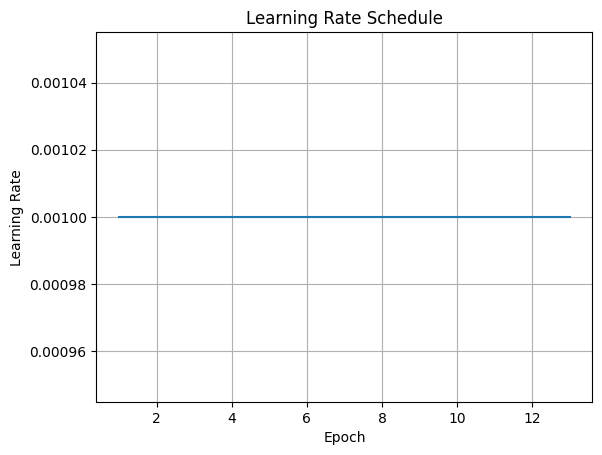

In [85]:
plt.plot(range(1, len(lr_history) + 1), lr_history)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()